$\textbf{Introduction}$

In this segment we will use LASSO with Cross Validation methods to estimate a large-scale VARX model with data on Chinese banks. The goal is to show how we can replicate the results discussed in the asychronous presentation.  

Again, the Elastic Net estimaiton proceeds as the solution to the penalized estimation:


$\beta_{Enet}=\stackrel{Min}{\beta}\left\{ \sum_{t=1}^{T}\left(y_{t}-\sum_{i}\beta_{i}x_{it}\right)^{2}+\lambda\sum_{i=1}^{k}\left[\left(\alpha|\beta_{i}|\right)+(1-\alpha)\beta_{i}^{2}\right]\right\}$

The parameters  $\alpha$ and $\lambda$ are $\textit{hyper-parameters}$.   With $\alpha=1$ the problem is to minimize the sume of absolute values of the estimate coefficients, and with $\alpha=0$ the problem is to minimize the sum of squares of the estimated programs.  The former is called LASSO estimation, while the latter is called Ridge regression.   Elastic net estimation implies a value of $\alpha$ between 0 and 1.   We will set the hyperparameter $\alpha=.5$.

The problem is to find the right value of $\lambda$ for minimizing the penalized sum-of-squared errors.   We do so by the Cross Validation method.

• In this approach, we select a grid of values for $\lambda$, between $\lambda=0$, and $\lambda^{*}$, the minimum $\lambda$ which sets all of the coefficients $\beta_{i}=0$.

• We then select a set of out-of-sample Mean Squared Error measures, based on holding out 20% of the sample for each specified $\lambda$ over the grid. 

• We thus select the optimal $\lambda$ as the one which minimizes the average out-of-sample mean squared error, based on five sets of hold-outs of 20% of the data. 

• We note that the coefficients $\left\{ \beta_{i}\right\}$  are based on the full in-sample elastic-net estimation with the pre-specified tuning parameter, $\alpha$, 

• We obtain the final optimal value of $\lambda$ from the cross-validation method. 

$\textbf{Chinese Banking Data and EPU Indices}$

Following the discussion of the VARX model, we have 17 series consisting of daily Range Volatility measures on 16 Chinese banks as well as the offshore CNH market based in Hong Kong.

We first load in the data for the Chinse banks (and Exchange Rate) as well as for the Conrols (the EPU indices)

In [1]:
!pip install matplotlib
!pip install arch
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels
import arch
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNetCV

In [2]:
TAB = pd.read_excel('China_All_Data.xls')
date1=TAB.loc[2:,1].reset_index(drop=True)
date2=date1.iloc[1:]
Controls = TAB.loc[3:,2:17].reset_index(drop=True).ffill()
SpotSpread = TAB.loc[2:,35:36].reset_index(drop=True).ffill()
SharePrice = TAB.loc[2:,37:].reset_index(drop=True).ffill()
(rshare, cshare) = SharePrice.shape

SharePrice = SharePrice.iloc[1:,:].reset_index(drop=True)
index1 = np.arange(0,cshare,4)
OpenPrice = SharePrice.iloc[:,index1]
index2 = np.arange(1,cshare,4)
HighPrice = SharePrice.iloc[:,index2]
index3 = np.arange(2,cshare,4)
LowPrice = SharePrice.iloc[:,index3]
index4 = np.arange(3,cshare,4)
ClosePrice = SharePrice.iloc[:,index4]

def rangefun(Data):
    data = np.log(Data);
    open = data.iloc[:,0];
    high =  data.iloc[:,1];
    low = data.iloc[:,2];
    close = data.iloc[:,3];
    rangevol =  .511*(high-low)**2-.019*((close-open)* (high+low-2*open)-2*(high-open)*(low-open))-.383*(close-open)**2
    return rangevol

(rRange, cRange) = ClosePrice.shape
RangeVol=np.zeros((rRange,cRange))
for i in range(cRange):
    Data=  pd.DataFrame([OpenPrice.iloc[:,i],HighPrice.iloc[:,i],LowPrice.iloc[:,i],ClosePrice.iloc[:,i]]).transpose()
    RangeVol[:,i] = rangefun(Data)

We normalize the RangeVol and Controls to values between 0 and 1.  This is also known as a $\textit{Squasher Function}$.

In [3]:
RangeVol1 = (RangeVol-RangeVol.min(0))/(RangeVol.max(axis=0)-RangeVol.min(0))
Controls1 = (Controls-Controls.min(0))/(Controls.max(axis=0)-Controls.min(0))
#plt.plot(date2,np.median(RangeVol1,1));

We now estimate the VAR model with the 5 lags for 17 series, with the Conrols.

In [5]:
numlags = 10
y = RangeVol1[numlags:]
x = Controls1[numlags:]
horizon = 20

Mdl = statsmodels.tsa.vector_ar.var_model.VAR(y,x)
EstMdl = Mdl.fit(maxlags=numlags)
Decomp1 = EstMdl.fevd(horizon).decomp[:,horizon-1,:]
Decomp2 = Decomp1 - np.diag(np.diag(Decomp1))
Decomp2 = Decomp2.T
Outward = Decomp2.sum(0)
Inward =  Decomp2.sum(1)
Net = Outward - Inward


We now do the Forecast Error Variance Decompostion for a horizon of 20.

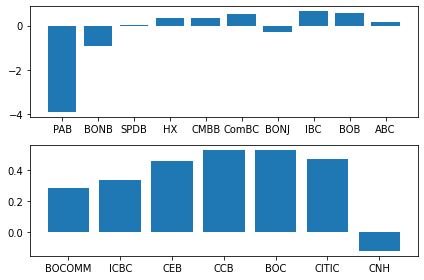

In [6]:
Decomp1 = EstMdl.fevd(horizon).decomp[:,horizon-1,:]
Decomp2 = Decomp1 - np.diag(np.diag(Decomp1))
Decomp2 = Decomp2.T
Outward = Decomp2.sum(0)
Inward =  Decomp2.sum(1)
Net = Outward - Inward

names =['PAB', 'BONB', 'SPDB', 'HX', 'CMBB', 'ComBC', 'BONJ', 'IBC', 'BOB', 'ABC']
names1 = ['BOCOMM', 'ICBC', 'CEB', 'CCB', 'BOC', 'CITIC', 'CNH']

fig,(ax1,ax2)=plt.subplots(2,1)
ax1.bar(names,Net[:10])
ax2.bar(names1,Net[10:])
plt.tight_layout()

For the Full Sample, we see that PAB and BONB have the largest outward effects for transmitting volatility.

There are 2166 observations in the model. Lets estimate the model and do the FEVD for the last 200 observations

Now let's look at the Esimation with Elastic Net (Combination of LASSO and Ridge Regression). There are two many parameters in the model. 17 state variables with 5 lags plus the constant terms and the Conrols for each of the 17 state variables.

In [7]:
def mlag(x,n=1,init=0):
    (nobs, nvar)=x.shape
    xlag=np.ones((nobs, nvar*n))*init
    for i in range(n):
        xlag[(i+1):,(i*nvar):((i+1)*nvar)]=np.roll(x,i+1,axis=0)[(i+1):]
    return xlag

In [8]:
xx=mlag(RangeVol1,numlags)
xxx=np.hstack([xx[numlags:],x])

In [9]:
!pip install sklearn
from sklearn.linear_model import ElasticNetCV
nfolds = 5
# l1_ratio = ratio
BETA=np.zeros((cRange*numlags+Controls1.shape[1],cRange))
for i in range(cRange):
    BETA[:,i]=ElasticNetCV(cv=nfolds,max_iter=2000, l1_ratio = .5).fit(xxx,y[:,i]).coef_

In [10]:
BETA

array([[ 0.10485292, -0.        ,  0.        , ..., -0.        ,
         0.        , -0.        ],
       [ 0.06935689,  0.20045137,  0.05442759, ...,  0.0884534 ,
         0.05202998, -0.        ],
       [-0.        , -0.        ,  0.09482458, ..., -0.        ,
        -0.        , -0.        ],
       ...,
       [-0.01337728,  0.        , -0.        , ...,  0.        ,
        -0.02661955, -0.0012841 ],
       [ 0.        ,  0.        ,  0.00405479, ...,  0.00296259,
         0.        ,  0.        ],
       [ 0.00222564,  0.00325448,  0.01525369, ...,  0.        ,
         0.0100746 ,  0.00979634]])

In [11]:
yhat_elasnet = np.dot(xxx,BETA)
ERROR = y - yhat_elasnet

In [12]:
sigma=np.dot(ERROR.T,ERROR)
variance=np.diag(sigma)

In [13]:
def calA(phi,h):
    A=[np.identity(cRange),phi[0]*np.identity(cRange)]
    for i in range(2,h+1):
        index=min(i,len(phi))
        ai=sum([m*n for m,n in zip(A[-index:],phi[:index])])
        A.append(ai)
    return A
            

In [14]:
phi=BETA[:cRange*numlags,:]
A=calA(phi,horizon)

In [15]:
VD=np.zeros((cRange,cRange))
for i in range(cRange):
    for j in range(cRange):
        VD[i,j]=1/variance[i]*sum([(np.dot(A[l],sigma)[i,j])**2 for l in range(len(A))])/sum([(np.dot(A[l],np.dot(sigma,A[l].T))[i,i]) for l in range(len(A))])
VD=VD/VD.sum(1).reshape(-1,1)

In [16]:
VD1=VD-np.diag(np.diag(VD))
Spillover1=VD1.sum()/VD.sum()
Spillover1

0.8984548700678187

In [17]:
Outward1=VD1.sum(0)
Inward1=VD1.sum(1)
Net1 = Outward1 - Inward1

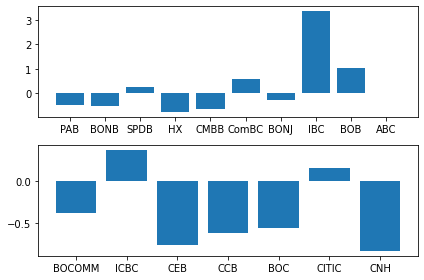

In [18]:
fig1,(ax11,ax12)=plt.subplots(2,1)
ax11.bar(names,Net1[:10])
ax12.bar(names1,Net1[10:])
plt.tight_layout()

In [27]:
BETA.shape

(186, 17)

In [28]:
#Number of elements in BETA
BETA.size

3162

In [29]:
#Number of non-zero elements in the elasticnet BETA
np.count_nonzero(BETA)

990